In [158]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

width  = 3.487
width = 10
height = width / 1.618

plt.rcParams['figure.figsize'] = (width, height)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8, titlesize=8)
plt.rc('text', usetex=True)
plt.style.use('ggplot')

In [2]:
class Chain(object):
    def __init__(self, value):
        self.d = 1.0
        self.v = value
        self.last = 0
        self.height = 0
        self.progress = 0

    def retarget(self, time):
        time_2016 = time - self.last
        self.last = time
        m = time_2016 / 20160.
        if m > 4:
            self.d /= 4
        elif m < 0.25:
            self.d *= 4
        else:
            self.d /= m
        return m

    def time_to_mine(self, hashpower):
        return self.d/hashpower*10.0
    
    def found(self, t):
        self.height += 1
        self.progress = 0.0
        if self.height % 2016 == 0:
            self.retarget(t)

In [3]:
class SplitManager(object):
    def __init__(self, alpha):
        assert 0 < alpha < 1
        self.alpha = alpha+0.0
        self.beta = 1 - alpha

        self.a = Chain(self.alpha)
        self.b = Chain(self.beta)

        self.a_subsidy = 0
        self.b_subsidy = 0
        self.t = 0.0

        if self.alpha > self.beta:
            self.hashpower_a(0.999)
        elif self.alpha < self.beta:
            self.hashpower_a(0.001)
        else:
            self.hashpower_a(0.5)

    def hashpower_a(self, hash_a):
        self.hash_a = hash_a
        self.hash_b = 1-hash_a

    @property
    def earned(self):
        return self.a.height*self.alpha + self.b.height*self.beta

    @property
    def foregone(self):
        return self.t/10

    def next(self):
        ta = self.a.time_to_mine(self.hash_a)
        tb = self.b.time_to_mine(self.hash_b)
        na = ta * (1.0 - self.a.progress)
        nb = tb * (1.0 - self.b.progress)
        pa = self.alpha/self.a.d
        pb = self.beta/self.b.d
        if na == nb: # simultaneous blocks!
            dt = na
            self.t += na
            self.a.found(self.t)
            self.b.found(self.t)
        elif na < nb: # a found a block first
            dt = na
            self.t += na
            self.a.found(self.t)
            self.b.progress += na/tb
        else: # b found a block first
            assert nb < na, "nb <> na -- %r %r" % (nb, na)
            dt = nb
            self.t += nb
            self.b.found(self.t)
            self.a.progress += nb/ta

        if pa>pb:
            self.b_subsidy += self.hash_b * (pa-pb) * (dt/10.0)
        else:
            self.a_subsidy += self.hash_a * (pb-pa) * (dt/10.0)

    @property
    def a_ret(self):
        return self.alpha/self.a.d
    @property
    def b_ret(self):
        return self.beta/self.b.d
    
    def done(self):
        if self.alpha > 0.5 or abs(self.a_ret-1) < 0.001:
            if self.beta > 0.5 or abs(self.b_ret-1) < 0.001:
                return self
#                return (self.alpha, self.beta, self.t, self.a.height, self.b.height, self.earned, self.foregone, self.a_subsidy, self.b_subsidy, a_ret, b_ret, self)
        return None


In [134]:
def try_fixed(alpha, debug=True):
    s = SplitManager(alpha)
    s.hashpower_a(alpha)
    chk = 0

    while s.t < 10*365*24*60:
        s.next()
        d = s.done()
        if d is not None:
            return d

        if debug and s.a.height >= chk + 2016:
            chk += 2016
            print("%3dd A: %3d %4.1f %.3f %.4f %.3f  B: %3d %4.1f %.3f %.4f %.3f   T: %10.3f  %10.3f %10.3f" % (s.t/24/60,
              s.a.height//2016, s.t/s.a.height, s.alpha, s.a.d, s.alpha/s.a.d, 
              s.b.height/2016, s.t/s.b.height, s.beta, s.b.d, s.beta/s.b.d, 
              (s.foregone-s.earned)*12.5, (s.a_subsidy+s.b_subsidy)*12.5, (s.foregone-s.earned-s.a_subsidy-s.b_subsidy)*12.5))
    return None

In [135]:
def try_ratioed(alpha, maxdrop):
    assert alpha >= 0.5
    s = SplitManager(alpha)
    hp = 1.0
    s.hashpower_a(0.0)
    chk = -1
    while s.t < 1*365*24*60:
        if s.b.height != chk and s.b.height % 2016 == 0 and hp > s.beta:
            if hp > maxdrop*s.beta:
                hp /= maxdrop
            else:
                hp = s.beta
            s.hashpower_a(1-hp)
        s.next()
        d = s.done()
        if d is not None:
            return d
            
        

In [136]:
def try_timeoptimal(alpha):
    assert alpha >= 0.5
    s = SplitManager(alpha)
    steps = math.ceil(-math.log(s.beta)/math.log(4))
    step = (s.beta*0.999)**(1.0/steps)
    hp = 1.0
    chk = -1
    while s.t < 1*365*24*60:      
        if s.b.height != chk and s.b.height % 2016 == 0 and hp > s.beta:
            chk = s.b.height
            hp *= step
            if hp < s.beta: hp = s.beta
            s.hashpower_a(1-hp)
        s.next()
        d = s.done()
        if d is not None:
            return d

In [219]:
# sigma = b/a, sigma < 1, a+b = 1
# sigma = (1-a)/a = 1/a-1
# sigma + 1 = 1/a
# a = 1/(sigma+1)
dom = np.linspace(0.001,1.0,250,endpoint=False)

chk = {}
chk["optimal"] = [try_timeoptimal(1/(d+1)) for d in dom]
print("done optimal")

# alternate approaches:

chk["fixed"] = [try_fixed(1/(d+1), debug=False) for d in dom]
print("done fixed")
#for drop in [1.1, 1.2, 2.0]:
#    chk["limit-%.1f" % drop] = [try_ratioed(d, maxdrop=drop) for d in dom]
#    print("done %.1f" % drop)

done optimal
done fixed


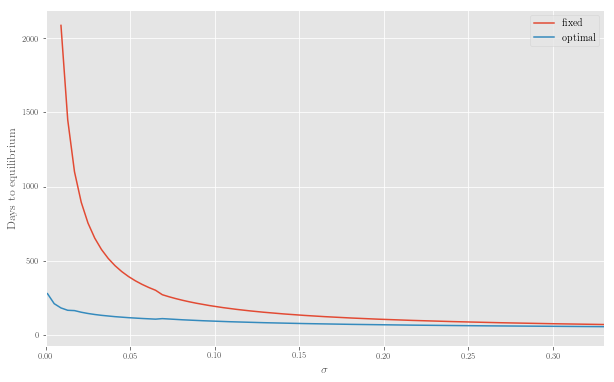

In [220]:
def equilib():
    plt.ylabel("Days to equilibrium")
    plt.xlabel('$\sigma$')
    plt.xlim(0,0.33)
    for c in sorted(chk):
        times = [r.t/60./24 if r is not None else None for r in chk[c]]
        plt.plot(dom, times, label=c)
    plt.legend()
equilib()

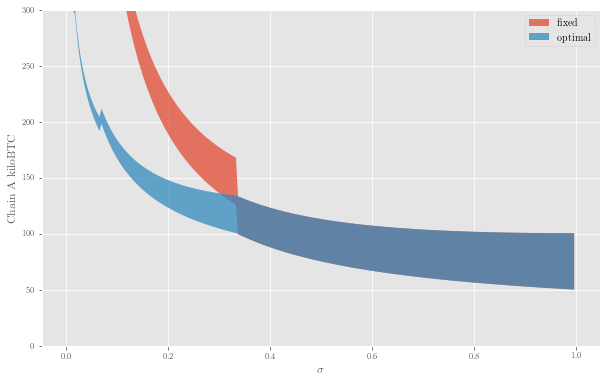

In [221]:
def foregone(q=chk):
    chk=q
    plt.ylabel("Chain A kiloBTC")
    plt.xlabel('$\sigma$')
    plt.ylim((0,300))
    for c in sorted(chk):
        # each coin foregone is worth at most (a+b), or (a+b)/b a coins
        lost_max = [12.5*r.foregone*(r.alpha+r.beta)/r.alpha/1000 if r is not None else 300 for r in chk[c]]
        # each coin foregone is worth at least (a), or a/a=1 a coin 
        lost_min = [12.5*r.foregone/1000 if r is not None else 300 for r in chk[c]]
        #plt.plot(dom, lost_max, label=c+" max")
        #plt.plot(dom, lost_min, label=c+" min")
        plt.fill_between(dom, lost_max, lost_min, label=c, alpha=0.75)
    plt.legend()

foregone()

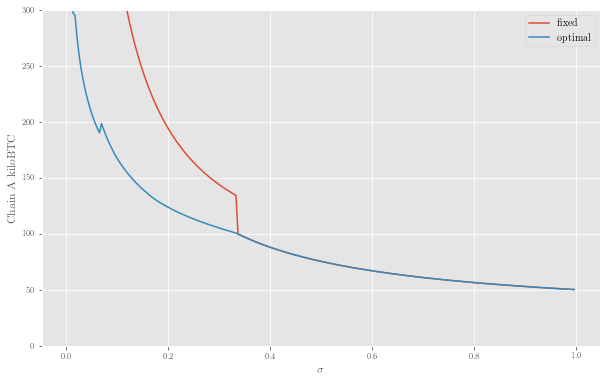

In [222]:

def earned():
    plt.ylabel("Chain A kiloBTC")
    plt.xlabel('$\sigma$')
    plt.ylim((0,300))
    for c in sorted(chk):
        lost = [12.5*r.earned*(r.alpha+r.beta)/r.alpha/1000 if r is not None else None for r in chk[c]]
        plt.plot(dom, lost, label=c)
    plt.legend()
    


#plt.subplot(212)
earned()

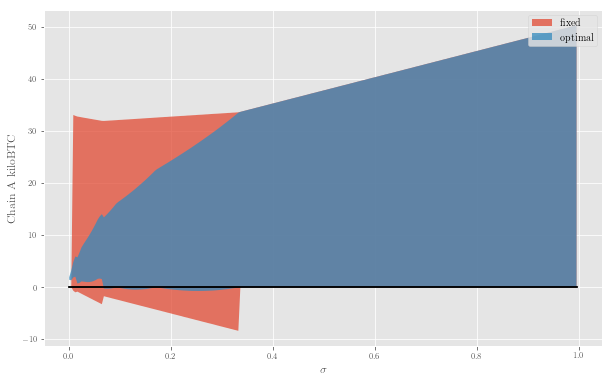

In [223]:
def lost(q=chk):
    chk=q
    plt.ylabel("Chain A kiloBTC")
    plt.xlabel('$\sigma$')
    for c in sorted(chk):
        # each unit of earned is alpha+beta
        # max lost is when r.foregone is highest, which is when each foregone coin is worth alpha+beta
        lost_max = [12.5*(r.foregone-r.earned)*(r.alpha+r.beta)/r.alpha/1000 if r is not None else 0 for r in chk[c]]
        # min lost is when r.foregone is lowest, which is when each unit is just worth alpha
        lost_min = [12.5*(r.foregone-(r.earned*(r.alpha+r.beta)/r.alpha))/1000 if r is not None else 0 for r in chk[c]]
        plt.fill_between(dom, lost_max, lost_min, label=c, alpha=0.75)
        plt.plot(dom, [0 for d in dom], color='k')
    plt.legend()

#lost(q={"optimal": chk["optimal"]})
lost()

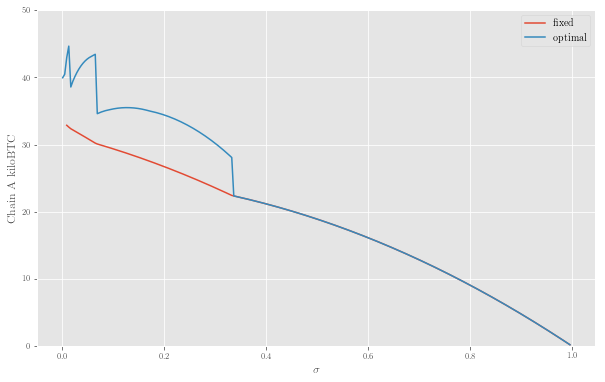

In [224]:
assert(all(r.a_subsidy == 0 for r in chk["optimal"]))

def subsidy():
    plt.ylabel("Chain A kiloBTC")
    plt.xlabel('$\sigma$')
    plt.ylim((0,50))
    for c in sorted(chk):
        subs = [12.5*r.b_subsidy*(r.alpha+r.beta)/r.alpha/1000 if r is not None and r.a_subsidy < 40000 else None for r in chk[c]]
        plt.plot(dom, subs, label=c)
    if len(chk) > 1: plt.legend()


subsidy()

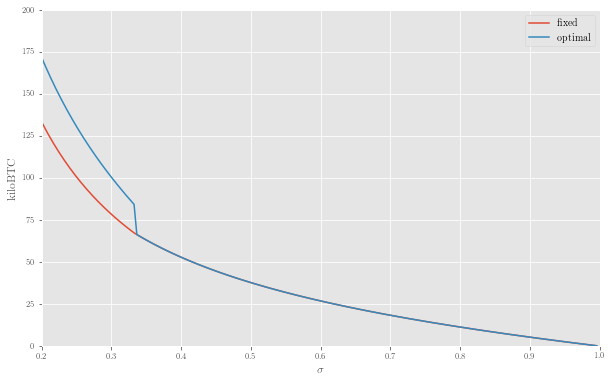

In [225]:
def subsidy_capital(xrange=None,yrange=None):
    plt.ylabel("kiloBTC")
    plt.xlabel('$\sigma$')
    #plt.yscale('log')
    if xrange is not None:
        plt.xlim(xrange)
    if yrange is not None:
        plt.ylim(yrange)
    for c in sorted(chk):
        subs = [12.5*r.b_subsidy*(r.alpha+r.beta)/r.alpha/1e3/(r.beta/r.alpha) if r is not None 
                and r.a_subsidy < 40000 else None for r in chk[c]]
        plt.plot(dom, subs, label=c)
    if len(chk) > 1: plt.legend()

subsidy_capital((0.2,1.0),(0,200))


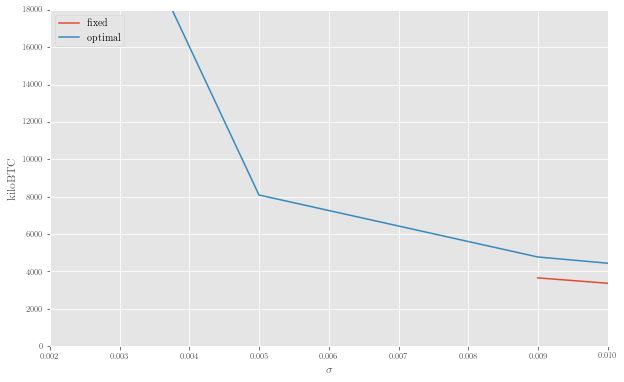

In [230]:
subsidy_capital((0.002,0.01),(0,18000))

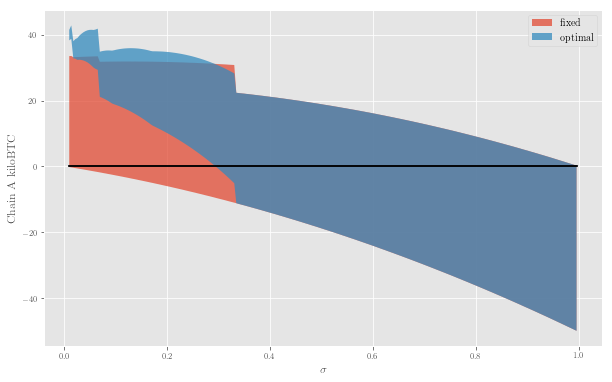

In [193]:
def subsidised_gain(q=chk):
    chk=q
    plt.ylabel("Chain A kiloBTC")
    plt.xlabel('$\sigma$')
    for c in sorted(chk):
        # each unit of earned is alpha+beta
        # max lost is when r.foregone is highest, which is when each foregone coin is worth alpha+beta
        lost_max = [12.5*(r.earned+r.b_subsidy-r.foregone)*(r.alpha+r.beta)/r.alpha/1000 if r is not None else None for r in chk[c]]
        # min lost is when r.foregone is lowest, which is when each unit is just worth beta
        lost_min = [12.5*((r.earned+r.b_subsidy)*(r.alpha+r.beta)/r.alpha-r.foregone)/1000 if r is not None else None for r in chk[c]]
        plt.fill_between(dom, lost_max, lost_min, label=c, alpha=0.75)
        plt.plot(dom, [0 for d in dom], color='k')
    plt.legend()
    
subsidised_gain()


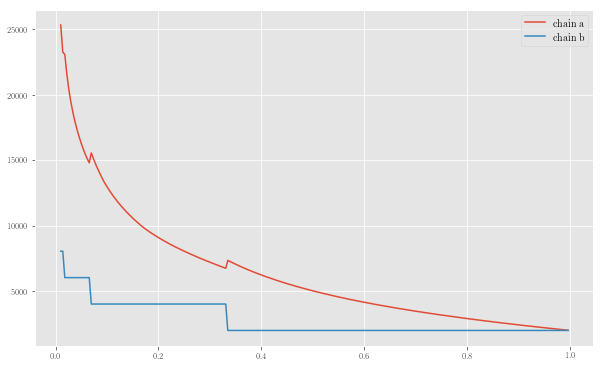

In [194]:
heights_a = [r.a.height if r is not None else None for r in chk["optimal"]]
heights_b = [r.b.height if r is not None else None for r in chk["optimal"]]
plt.plot(dom, heights_a, label="chain a")
plt.plot(dom, heights_b, label="chain b")
plt.legend()

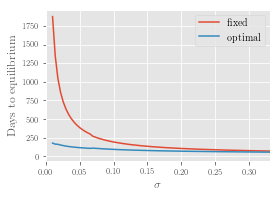

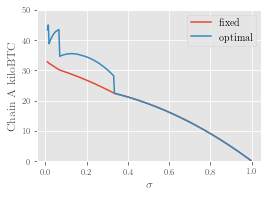

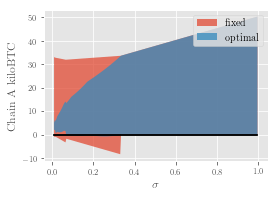

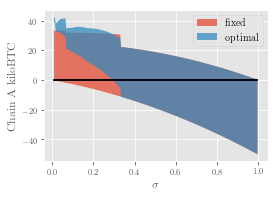

In [197]:
width  = 4.2
height = width / 1.618

fig, ax = plt.subplots(figsize=(width, height))
fig.subplots_adjust(left=.25, bottom=.16, right=.99, top=.97)
equilib()
plt.savefig('lifetime.pdf', dpi=200)

fig, ax = plt.subplots(figsize=(width, height))
fig.subplots_adjust(left=.25, bottom=.16, right=.99, top=.97)
subsidy()
plt.savefig('costs.pdf', dpi=200)

fig, ax = plt.subplots(figsize=(width, height))
fig.subplots_adjust(left=.25, bottom=.16, right=.99, top=.97)
lost()
plt.savefig('foregone.pdf', dpi=200)

fig, ax = plt.subplots(figsize=(width, height))
fig.subplots_adjust(left=.25, bottom=.16, right=.99, top=.97)
subsidised_gain()
plt.savefig('subgain.pdf', dpi=200)